# Semantic Segmentation on Indian Driving Dataset

## 1. Business Problem

### 1.1. Problem Overview

- Most of the datasets for autonomous navigation tend to focus on structured driving environments. This usually corresponds to well-delineated infrastructures such as lanes, a small number of well-deﬁned categories for traﬃc participants, low variation  in an object or background appearance, and strong adherence to traﬃc rules.
- Indian Driving Dataset (IDD) is a collection of autonomous driving annotated street-level images captured on Indian roads, and formatted to facilitate use for the purpose of training AI systems and neural networks. It consists of images from unstructured environments where the above assumptions are largely not satisfied. It reflects label distributions of road scenes significantly different from existing datasets, with most classes displaying greater within-class diversity. Consistent with real driving behaviors, it also identifies new classes such as drivable areas besides the road.
- It is difficult to completely avoid ambiguity between some labels. For example labels like parking, caravan, or trailer cannot be precisely defined due to the diversity of the scenes and vehicles in the data collected. For resolving this issue, the dataset is designed as a 4 level label hierarchy having 7 (level 1), 16 (level 2), 26 (level 3), and 30 (level 4) labels.
- The images are obtained from a front-facing camera attached to a car. The car was driven around Hyderabad, Bangalore cities and their outskirts. <br> <br>
Source - http://idd.insaan.iiit.ac.in/


### 1.2 Data

- There are 1403 train images, 204 validation images and 404 test images
- Shape of the input image and segmentation masks given: [227,320,3]
- Shape of the output segmentation mask expected: [256,128]
<br> <br>
Source - http://idd.insaan.iiit.ac.in/dataset/download/

### 1.3 Challenge

- The idd20k_lite dataset has 7 classes that include Drivable, Non-Drivable, Living things, Vehicles, Road-side objects, Far-objects, and Sky.
- The segmentation challenge is the pixel-level prediction of all the 7 classes at level 1 of the label hierarchy.
- The predictions are supposed to be png images, with the size of 256x128. Each pixel of this image contains the label as level1Ids (see labels code [here](https://github.com/AutoNUE/public-code/blob/312a6ba2219a39fe8b105e44ad0612079249bad8/helpers/anue_labels.py#L40)) of the corresponding image (resized to 256x128). The evaluation code resizes both your prediction and ground truth png files to 256x128, in case they are not of that size.
<br><br> Source - http://idd.insaan.iiit.ac.in/evaluation/ncv19-leader-board/

### 1.4 Performance Metric

- mIoU <br><br>
The performance metric is Mean-Intersection-Over-Union (mIoU). mIoU is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes.


In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.12.0


## Loading the Dataset

In [ ]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = '/content/drive/MyDrive/ee8208project/idd20k_lite/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

## Data Visualization

### Sample Training Image

### Plotting the image

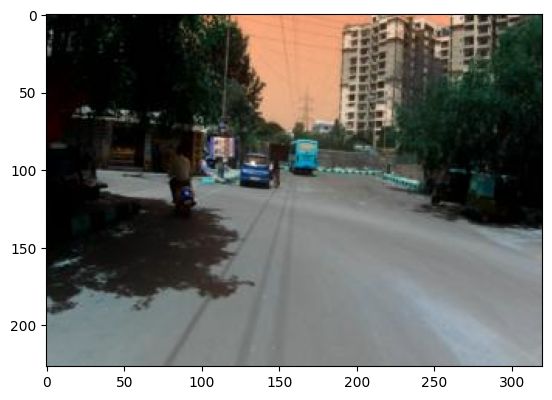

In [ ]:
# Reading a sample image and plotting it
img = cv2.imread(img_train+'29/972458_image.jpg',1)
plt.imshow(img)

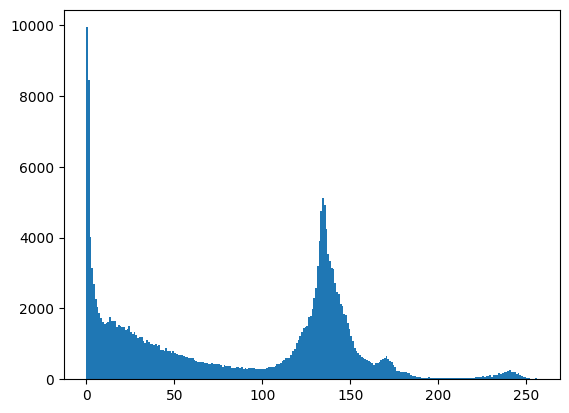

In [ ]:
# Plotting an Histogram to find the frequency of pixel intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

<b> From the above histogram plot, we get the distribution of the pixel intensity values in the given image. </b>

### Annotated Images

<b> What is Image Annotation? </b>

It is a process of labeling the data (available in the format of images), to make the object in the image recognizable to machines through computer vision technology. Basically, its used to detect, classify and group the objects in machine learning training.

### Plotting the given annotated image

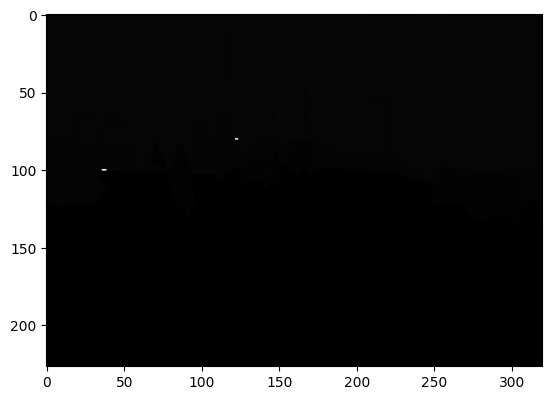

In [ ]:
# Reading the given annotated image for the above sample image
img = cv2.imread(seg_train+'29/972458_label.png',1)
plt.imshow(img)

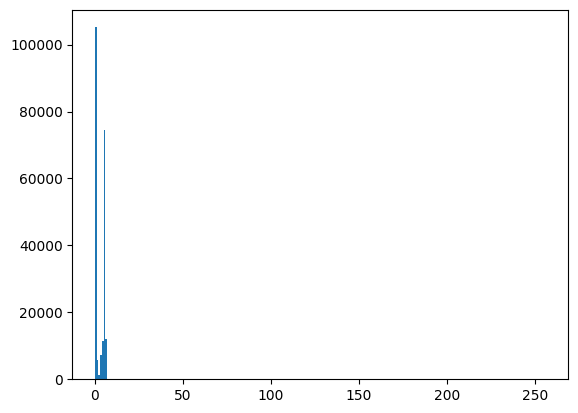

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii, y[ii])).T

array([[     0, 105186],
       [     1,   5832],
       [     2,   1416],
       [     3,   7371],
       [     4,  11481],
       [     5,  74550],
       [     6,  12069],
       [   255,     15]])

<b> We can observe that, in the annotated image, all of the pixel intensity values are from 0-6 and there are some pixels of the value 255. So, let's get a closer look to the plot in the range 0-6. </b>

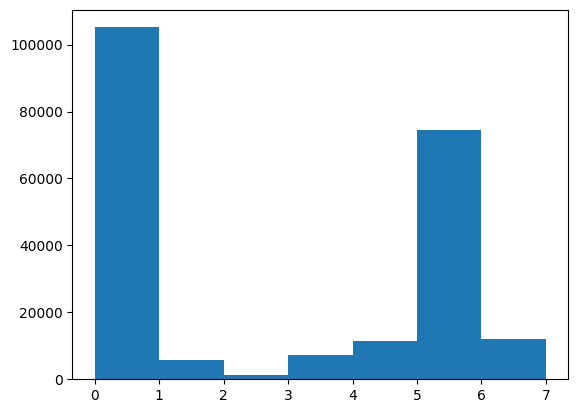

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),7,[0,7])
plt.show()

<b> So, in the given annotated image, all the pixels (excluding the pixel value 255) are from the range 0-6 (for 7 classes). We can intensify these pixels to get clearer annotations, as with a wider range of pixels, it will be easier to distinguish between the pixels as colors vary on a wider range. We will multiply each pixel, excluding 0 and 255 with 40, so we will get different colors with a difference of larger values. </b>

### Plotting the annotated image after intensifying the pixels

In [ ]:
# This function visualizes the segmenetation image by multiplying each pixel with 40
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] ==255:
                img_seg[i][j] =7
    return img_seg

In [ ]:
# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train+'29/972458_label.png')
print(np.unique(img_seg))

[0 1 2 3 4 5 6 7]


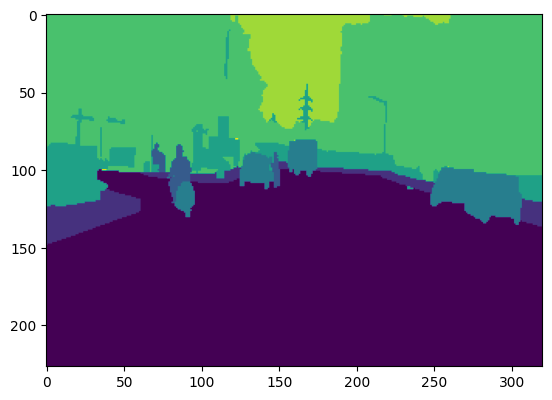

In [ ]:
# Plotting the processed segmentation image
plt.imshow(img_seg)

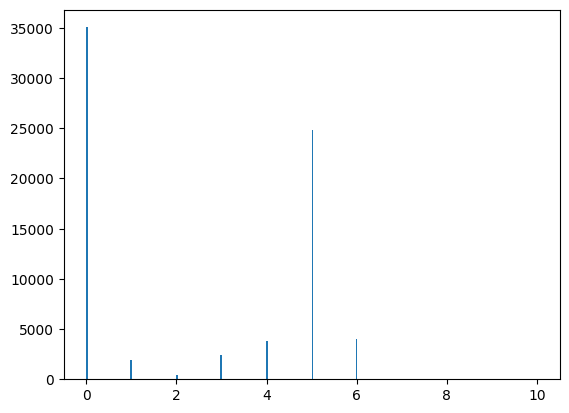

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,10])
plt.show()

<b> Now, we can easily distinguish the objects after intensifying the pixels as there are colors vary on a wider range, so it is easy to visualize the annotated image. </b>

## Data Preparation

<b>References </b> <br>
https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/ <br>
https://www.tensorflow.org/tutorials/load_data/images <br>
https://www.tensorflow.org/tutorials/images/segmentation

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
# Reference -> https://docs.python.org/2/library/glob.html
# The glob module finds all the pathnames matching a specified pattern according to
# the rules used by the Unix shell, although results are returned in arbitrary order.

TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1403 images.
The Validation Dataset contains 204 images.


In [ ]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=1)
    # In scene parsing, "not labeled"  = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
#mask=parse_image(seg_train+'29/972458_label.png')
#print(np.unique(mask))

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/image/resize
# Resize images to the size specified

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


## Visualizing after processing the data

In [ ]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
# Getting a sample image for visualizing
i=1
for image, mask in dataset['train'].take(i):
    sample_image, sample_mask = image, mask

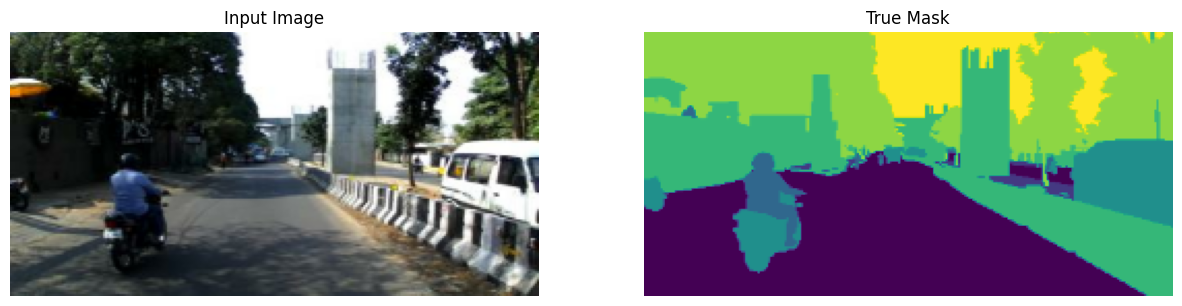

[0.         0.00732422 0.00927734 0.00976562 0.01464844 0.015625
 0.01953125 0.02929688 0.03076172 0.05126953 0.06054688 0.06103516
 0.06152344 0.06835938 0.07421875 0.078125   0.08349609 0.08789062
 0.09228516 0.09570312 0.11328125 0.11523438 0.1274414  0.12988281
 0.18310547 0.19628906 0.1977539  0.19824219 0.20507812 0.21240234
 0.234375   0.24169922 0.25       0.26757812 0.26953125 0.2841797
 0.28564453 0.28710938 0.29296875 0.2939453  0.29492188 0.30078125
 0.3076172  0.31445312 0.32226562 0.32666016 0.33251953 0.3359375
 0.33984375 0.34179688 0.36914062 0.375      0.38085938 0.3881836
 0.39648438 0.40429688 0.41601562 0.42236328 0.42773438 0.46142578
 0.4658203  0.48632812 0.49072266 0.49414062 0.5        0.5097656
 0.51660156 0.52734375 0.52978516 0.5332031  0.55810547 0.5683594
 0.5864258  0.58740234 0.5957031  0.5991211  0.609375   0.6123047
 0.6152344  0.62109375 0.625      0.6269531  0.63134766 0.640625
 0.6503906  0.66748047 0.6723633  0.69140625 0.703125   0.7050781
 0.708

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[31], sample_mask[31]])

print(np.unique(sample_mask[31]))

In [ ]:
x_train=[]
x_mask=[]

for i in range(44):
  for image, mask in dataset['train'].take(i):
      sample_image, sample_mask = image, mask
  for j in range(len(sample_image)):
    x_train.append(sample_image[j])
    x_mask.append(sample_mask[j])



In [ ]:
x_val=[]
mask_val=[]

for i in range(44):
  for image, mask in dataset['val'].take(i):
      sample_image, sample_mask = image, mask
  for j in range(len(sample_image)):
    x_val.append(sample_image[j])
    mask_val.append(sample_mask[j])


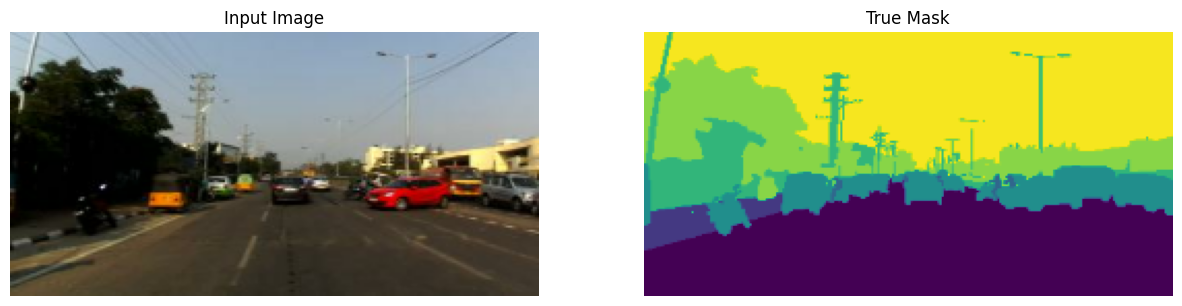

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[31], sample_mask[31]])

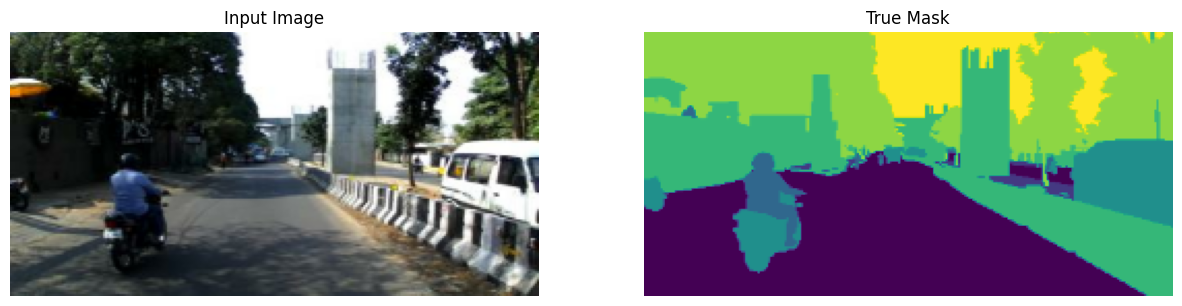

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([x_train[31], x_mask[31]])

In [ ]:
x_train = np.array(x_train)
print(x_train[31].shape)


(128, 256, 3)


In [ ]:
print(x_train.shape)

(1408, 128, 256, 3)


In [ ]:
x_mask = np.array(x_mask)
print(x_mask.shape)

(1408, 128, 256, 1)


In [ ]:
x_val=np.array(x_val)
print(x_val.shape)

(1408, 128, 256, 3)


In [ ]:
mask_val=np.array(mask_val)
print(mask_val.shape)

(1408, 128, 256, 1)


In [ ]:
from keras.utils import to_categorical
y_train_temp= to_categorical(x_mask, num_classes=N_CLASSES)
y_train = y_train_temp.reshape((y_train_temp.shape[0], y_train_temp.shape[1], y_train_temp.shape[2], N_CLASSES))

print(y_train.shape)


(1408, 128, 256, 8)


In [ ]:
from keras.utils import to_categorical
y_val_temp= to_categorical(mask_val, num_classes=N_CLASSES)
y_val = y_val_temp.reshape((y_val_temp.shape[0], y_val_temp.shape[1], y_val_temp.shape[2], N_CLASSES))

print(y_val.shape)

(1408, 128, 256, 8)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [ ]:
def get_model():
    return multi_unet_model(n_classes=N_CLASSES, IMG_HEIGHT=HEIGHT, IMG_WIDTH=WIDTH, IMG_CHANNELS=N_CHANNELS)

model = get_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()
#If starting with pre-trained weights.
#model.load_weights('???.hdf5')

history = model.fit(x_train,y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=50,
                    validation_data=(x_val, y_val))


model.save('200epochs_batch32_unet_nodropout.hdf5')




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 256, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

44/44 [==============================] - 3s 72ms/step - loss: 0.5546 - acc: 0.8372
Accuracy is =  83.71899127960205 %


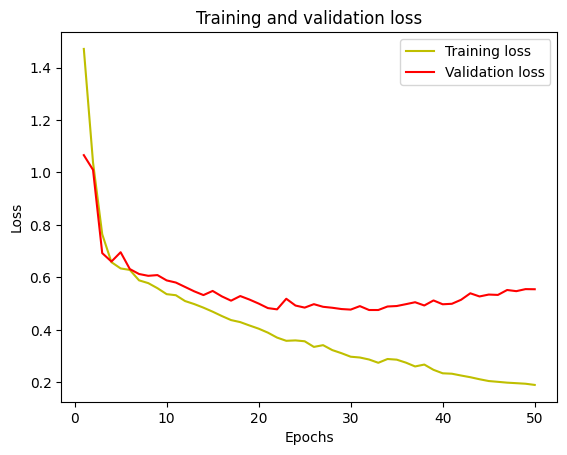

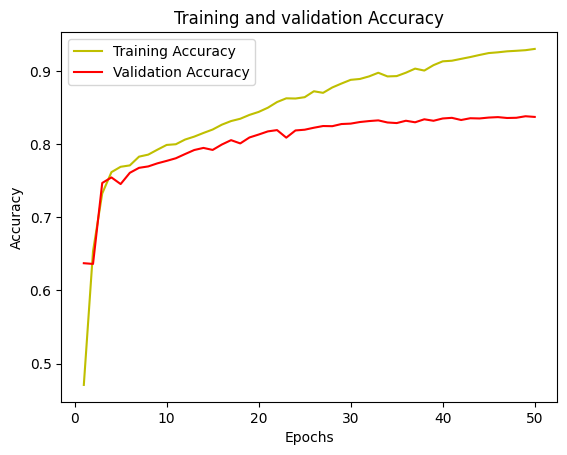

In [ ]:
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(x_val, y_val)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    # Uncomment this when you want to display the results
    #display_sample([input_image, image_mask, pred_mask])

    colors = np.array([
    [128, 64, 18],  # Drivable
    [244, 35, 232],  # Non Drivable
    [220, 20, 60],  # Living Things
    [0, 0, 230],  # Vehicles
    [220, 190, 40],  # Road Side Objects
    [70, 70, 70],  # Far Objects
    [70, 130, 180],  # Sky
    [0, 0, 0]  # Misc
    ], dtype=int)


    return image_mask, pred_mask

In [ ]:
# Calling the predict function
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/EE8204Project/idd20k_lite/leftImg8bit/val/21/240284_image.jpg')


In [ ]:
print(pred_mask.shape)

(128, 256, 1)


In [ ]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    temp=cv2.imread(display_list[0],1)
    display_list[0]=temp
    title = ['Input Image','True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow((display_list[i]))
        plt.axis('off')
    plt.show()


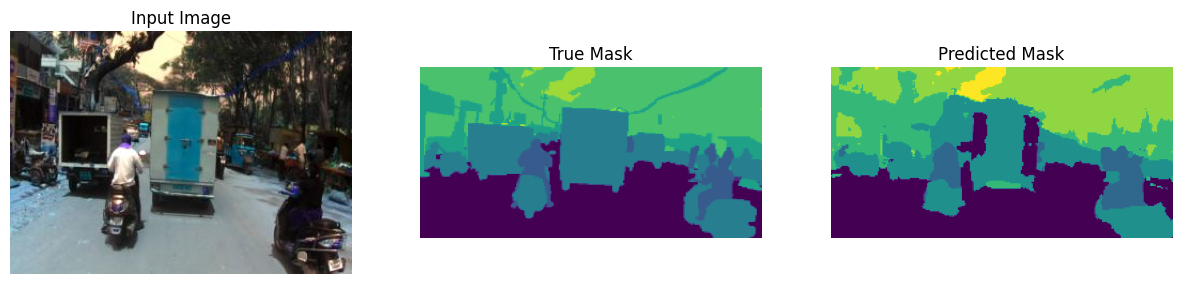

In [ ]:
trueimgpath='/content/drive/MyDrive/EE8204Project/idd20k_lite/leftImg8bit/val/21/240284_image.jpg'
display_sample([trueimgpath,true_mask,pred_mask,])

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        # print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    # Uncomment this when you want to print the mean IoU
    #print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
IoU(true_mask, pred_mask)

0.48757788313820427

Reload the Model and Run for another 100 epochs

In [ ]:
# Loading the weights of the best model

# loading the saved model
loaded_model = tf.keras.models.load_model('200epochs_batch32_unet_nodropout.hdf5')

# retraining the model
loaded_model.fit(x_train, y_train,batch_size = 32, epochs = 50, validation_data = (x_val,y_val),verbose=1)
model.save('100_more_epochs__unet.hdf5')


In [ ]:
############################################################
#Evaluate the model
	# evaluate model
_, acc = loaded_model.evaluate(x_val, y_val)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss After 100 more Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy After 100 More Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
true_mask1, pred_mask1 = predict(model,'/content/drive/MyDrive/EE8204Project/idd20k_lite/leftImg8bit/val/21/240284_image.jpg')

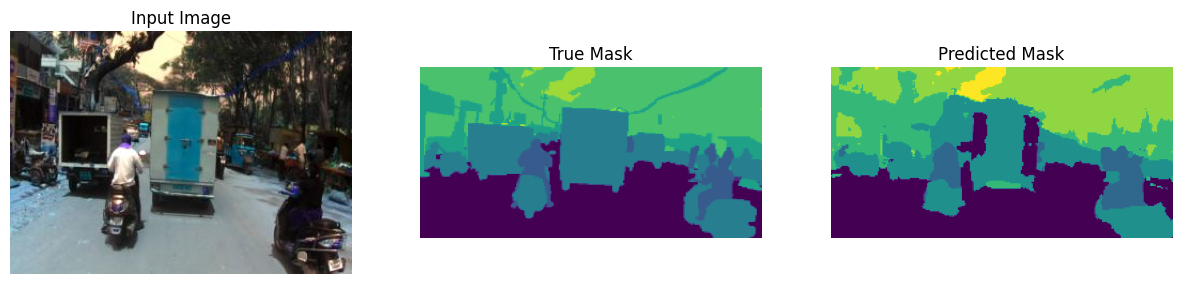

In [ ]:
trueimgpath='/content/drive/MyDrive/EE8204Project/idd20k_lite/leftImg8bit/val/21/240284_image.jpg'
display_sample([trueimgpath,true_mask1,pred_mask1,])

In [ ]:
IoU(true_mask, pred_mask)

0.48757788313820427

## Validation Results

### Getting the mIoU for all the validation images

In [ ]:
# Getting the paths of all validation images
img_val = dataset_path + 'leftImg8bit/val/'
val_paths = glob(img_val+'*/*_image.jpg')

In [ ]:
# Getting the mIoU for all the validation image predictions and storing it in a list
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(model,path)
    mIoU.append(IoU(true_mask, pred_mask))

In [ ]:
# Getting the average mIoU for all the validation images
print("Validation mIoU = ",sum(mIoU)/len(mIoU))

Validation mIoU =  0.4559993388883448


after more epochs

In [ ]:
# Getting the mIoU for all the validation image predictions and storing it in a list
mIoU = []
for path in val_paths:
    true_mask, pred_mask = predict(loaded_model,path)
    mIoU.append(IoU(true_mask, pred_mask))

# Getting the average mIoU for all the validation images
print("Validation mIoU = ",sum(mIoU)/len(mIoU))

## Observations

<b> The average mIoU of all the validation images is <i>0.448</i> </b>

# Prediction of Test Images for UNet model

## Observations

In [ ]:
from prettytable import PrettyTable

# Representing results in a table
pt = PrettyTable()

pt.field_names = ["Model", "Highest Accuracy", "Validation mIoU"]
pt.add_row(["UNet",83.72,0.466])
print(pt)

+-------+------------------+-----------------+
| Model | Highest Accuracy | Validation mIoU |
+-------+------------------+-----------------+
|  UNet |      83.72       |      0.466      |
+-------+------------------+-----------------+


We can observe that UNet performs better on this dataset.  

- https://arxiv.org/pdf/1612.01105.pdf
- https://arxiv.org/pdf/1505.04597.pdf
- https://github.com/saisandeepNSS/IDD_SemanticSegmentation
- https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/
- https://medium.com/analytics-vidhya/semantic-segmentation-in-pspnet-with-implementation-in-keras-4843d05fc025
- https://github.com/junhoning/machine_learning_tutorial/
